In [10]:
import bagpipes as pipes
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import scienceplots as scipl
import math
import os
import scipy
from scipy import integrate
#import mpld3
#import streamlit as st
#import streamlit.components.v1 as components

exp = {}                                # Tau model star formation history component 
exp["age"] = 3                          # Gyr 
exp["tau"] = 0.25                       # Gyr -- tau provides exponential decay ∙•●✴︎◦°∙ FOR SINGLE STARBURST MAKE TAU SMALLER (0.25)
exp["massformed"] = 10.                 # log_10(M*/M_solar) -- galaxy 10e9 > Sun
exp["metallicity"] = 1                  # Z/Z_oldsolar -- 0.5met_solar

dust = {}                               # Dust component
dust["type"] = "Calzetti"               # Define the shape of the attenuation curve
dust["Av"] = 0                          # magnitudes

burst = {}                              # Delta function burst
burst["age"] = 0.5                      # Time since burst: Gyr
burst["massformed"] = 8.6 
burst["metallicity"] = 1

model_components = {}                   # The model components dictionary
model_components["redshift"] = 0.35     # Observed redshift  
model_components["burst"] = burst
model_components["dust"] = dust

In [11]:
hst_filter_list = np.loadtxt('filters.txt', dtype='str')
jwst_filter_list = np.loadtxt('filters.txt', dtype='str')

In [12]:
model = pipes.model_galaxy(model_components, filt_list=jwst_filter_list, spec_wavs=np.arange(0, 51000, 10))

In [13]:
import sys
 
 
def findClosest(arr, n, target):
    left, right = 0, n - 1
    while left < right:
        if abs(arr[left] - target) <= abs(arr[right] - target):
            right -= 1
        else:
            left += 1
    return arr[left]

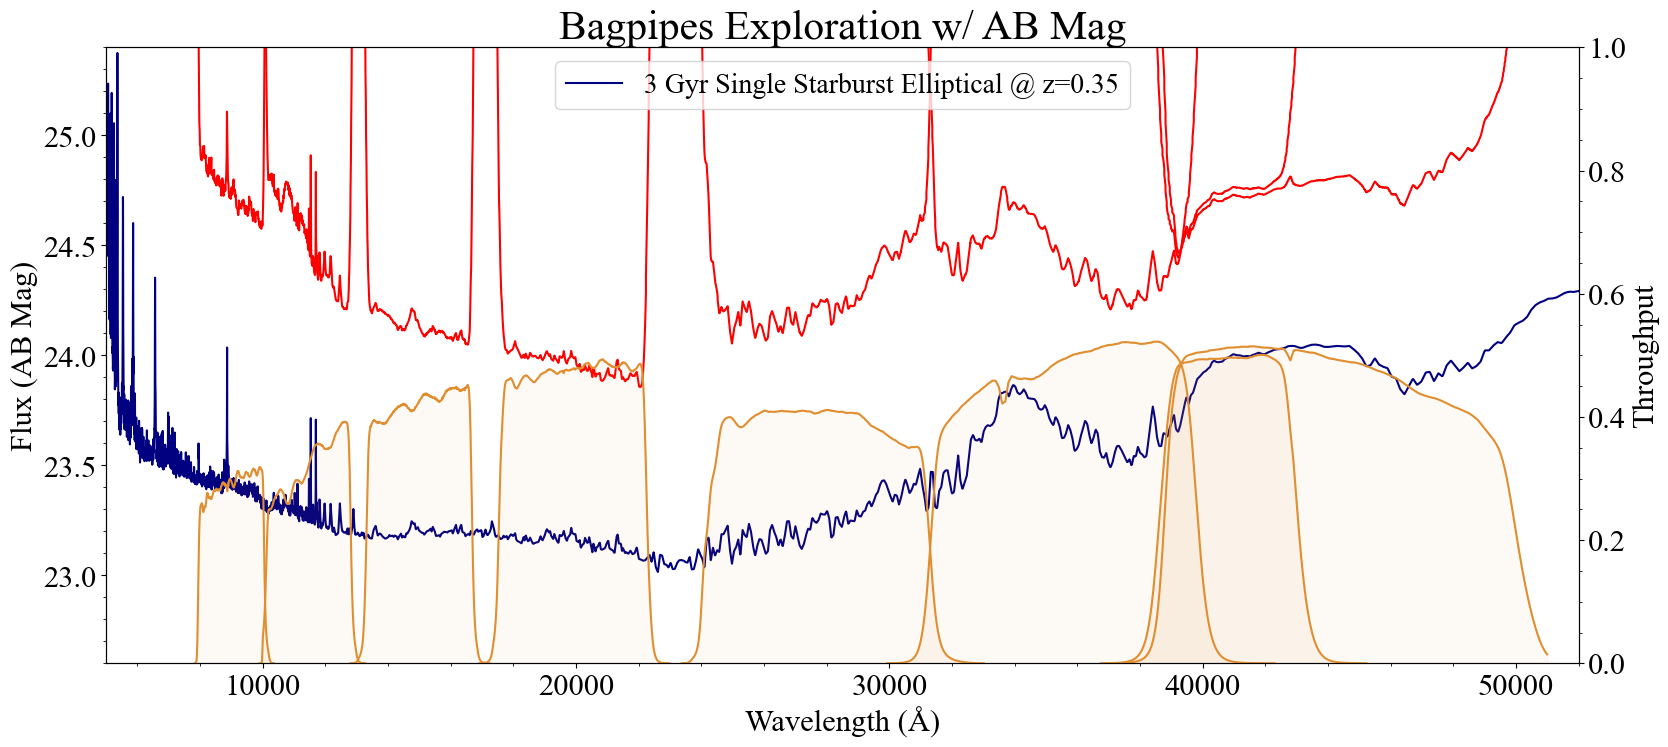

In [14]:
from scipy import integrate

#fig, ax = model.plot(show = False)
#print(ax)
#ax[0].set_xlabel('lambda / A')
#ax[0].set_xlim(4000, 49000)

x = model.wavelengths * (1 + model_components['redshift'])
y = model.spectrum_full #the graph gives 10^-18.0 erg s^-1 cm^-2 A^-1

# print('F𝝀:') #10^-18.0 erg s^-1 cm^-2 A^-1
# print(y)

#fig, ax = plt.subplots(figsize=(19,8))
#plt.plot(x, y, label='Plot', drawstyle='default', color='navy')
#plt.xscale('linear')
#plt.yscale('linear')
#ax.minorticks_on()
#ax.set_xlabel('Wavelength (Å)', fontsize=22)
#ax.set_ylabel('F lambda (10^-18.0 erg s^-1 cm^-2 A^-1)')
#ax.set_ylim(0, np.max(y))
#ax.set_xlim(5000, 45000)

ab_mag = []
f_nu = []

for n in range(0, len(y), 1):
    conversion = (((x[n])**2)/(3e18)) * y[n]
    f_nu.append(conversion)

# print('F𝜈:') #10^-29.0 erg s^-1 cm^-2 Hz^-1
# print(f_nu)

#fig, ax = plt.subplots(figsize=(19,8))
#plt.plot(x, f_nu, label='Plot', drawstyle='default', color='red')
#plt.xscale('linear')
#plt.yscale('linear')
#ax.minorticks_on()
#ax.set_xlabel('Wavelength (Å)', fontsize=22)
#ax.set_ylabel('F nu (10^-29.0 erg s^-1 cm^-2 Hz^-1)')
#ax.set_ylim(0, np.max(f_nu))
#ax.set_xlim(5000, 45000)

for n in range(0, len(f_nu), 1):
    if float(f_nu[n]) != 0:
        AB = (-2.5 * np.log10(float(f_nu[n]))) - 48.6
        ab_mag.append(float(AB))
    else:
        ab_mag.append(0)

# print('\nWavelength')
# print(x)

# print('AB Mag:') #Mag
# print(ab_mag)

# CONTINUUM SPECTRA PLOTTING

fig, ax = plt.subplots(figsize=(19,8))

wavs = x
flux = ab_mag

plt.xscale('linear')
plt.yscale('linear')

Con, = ax.plot(wavs, flux, drawstyle='default', color='navy', label=str(exp["age"]) + ' Gyr Single Starburst Elliptical @ z=' + str(model_components["redshift"]))

ax.set_xlabel('Wavelength (Å)', fontsize=22)
ax.set_ylabel('Flux (AB Mag)', fontsize=22)

ax.set_ylim(22.6, 25.4) #(22.6, 25.4)
ax.set_xlim(5000, 52000)


ax.legend(handles=[Con], loc='upper center', prop={'family': 'Times New Roman', 'size': '20'})

# FILTER PLOTTING

filters = '''   JWST_NIRCam.F090W.dat
                JWST_NIRCam.F115W.dat
                JWST_NIRCam.F150W.dat
                JWST_NIRCam.F200W.dat
                JWST_NIRCam.F277W.dat
                JWST_NIRCam.F356W.dat
                JWST_NIRCam.F444W.dat
                JWST_NIRCam.F410M.dat
'''

ax2 = ax.twinx()

for filename in os.listdir('filters/'):
    if filename in filters:
        file = open('filters/'+filename, 'r')

        wavsrange = []
        through = []

        for line in file:
            pair = line.strip().split(' ')
            wavsrange.append(float(pair[0]))
            through.append(float(pair[1]))
        
        ax2.plot(wavsrange, through, color='#E08E2F')
        ax2.fill_between(wavsrange, through, color='#E08E2F', alpha=0.05)

        # SYNTHETIC ASTRO COLOUR

        colour = []
        colourrange = []

        for n in range(0, len(wavsrange), 1):

            closestwav = findClosest(wavs, len(wavs), wavsrange[n]) # closest value in wavs to wavsrange[n] is closestwav
            wavs_lis = wavs.tolist()

            mag = through[n] * f_nu[wavs_lis.index(closestwav)]
            plotted_mag = (-2.5 * np.log10(mag)) - 48.6

            colourrange.append(closestwav)
            colour.append(plotted_mag)

        ax.plot(colourrange, colour, color='red')

ax2.set_ylabel('Throughput', fontsize=22)

ax2.set_ylim(0, 1)
ax2.set_xlim(5000,52000)

# TICK ADJUSTMENTS

ax.minorticks_on()
ax.tick_params(labelsize=22)
ax2.minorticks_on()
ax2.tick_params(labelsize=22)
plt.rcParams.update({'font.serif': "Times New Roman",
                     'font.family': "serif"                  
                    })

plt.title('Bagpipes Exploration w/ AB Mag', fontsize=30)
#fig_html = mpld3.fig_to_html(fig)
#components.html(fig_html, height=600)
plt.show()

# Arc 2 spectra -- try this and compare to Nick

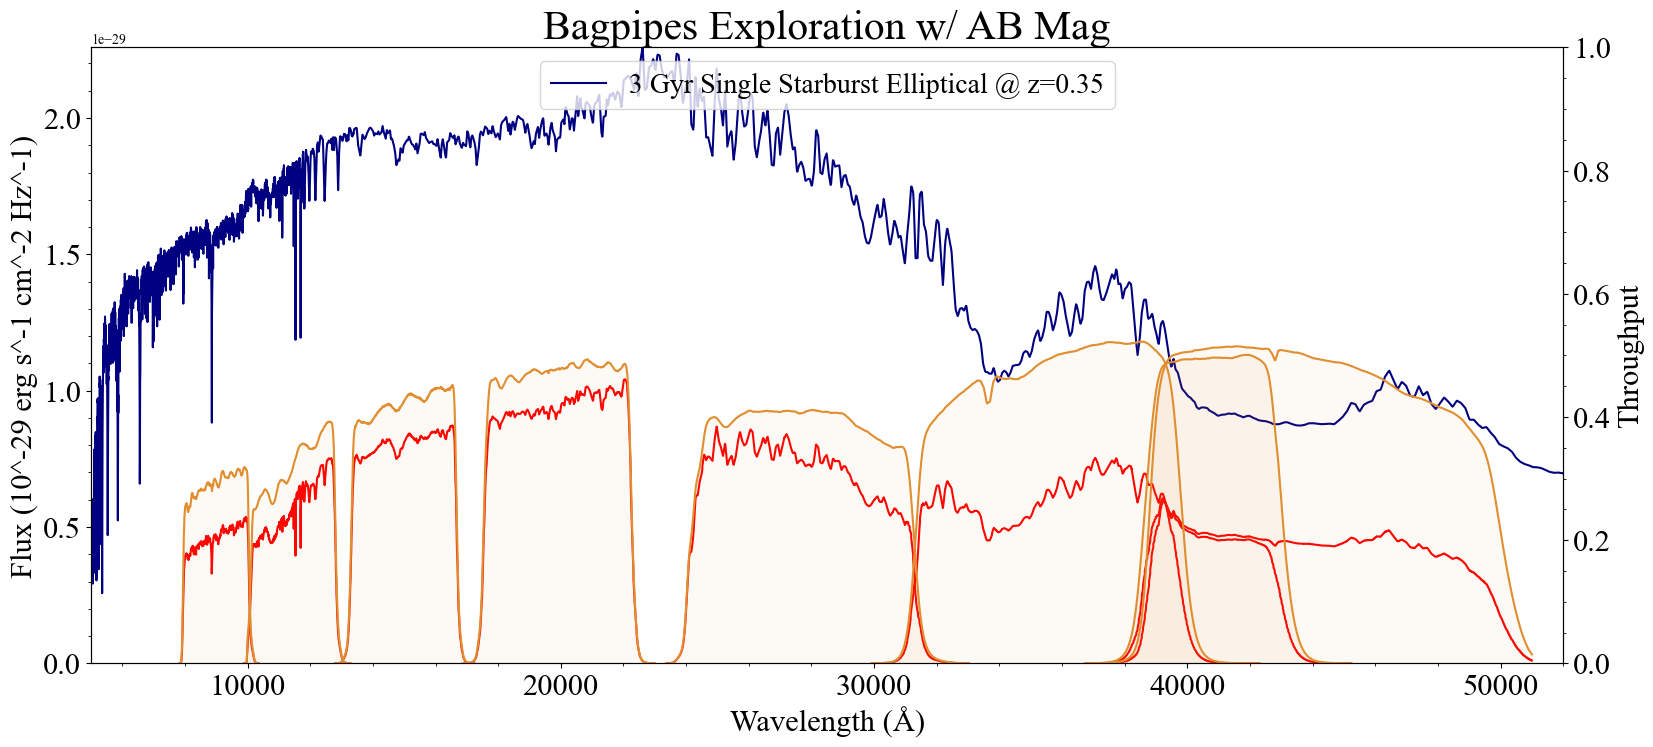

In [15]:
fig, ax = plt.subplots(figsize=(19,8))

wavs = x
flux = f_nu

plt.xscale('linear')
plt.yscale('linear')

Con, = ax.plot(wavs, flux, drawstyle='default', color='navy', label=str(exp["age"]) + ' Gyr Single Starburst Elliptical @ z=' + str(model_components["redshift"]))

ax.set_xlabel('Wavelength (Å)', fontsize=22)
ax.set_ylabel('Flux (10^-29 erg s^-1 cm^-2 Hz^-1)', fontsize=22)

ax.set_ylim(0, np.max(f_nu)) #(22.6, 25.4)
ax.set_xlim(5000, 52000)


ax.legend(handles=[Con], loc='upper center', prop={'family': 'Times New Roman', 'size': '20'})

# FILTER PLOTTING

filters = '''   JWST_NIRCam.F090W.dat
                JWST_NIRCam.F115W.dat
                JWST_NIRCam.F150W.dat
                JWST_NIRCam.F200W.dat
                JWST_NIRCam.F277W.dat
                JWST_NIRCam.F356W.dat
                JWST_NIRCam.F444W.dat
                JWST_NIRCam.F410M.dat
'''

ax2 = ax.twinx()

for filename in os.listdir('filters/'):
    if filename in filters:
        file = open('filters/'+filename, 'r')

        wavsrange = []
        through = []

        for line in file:
            pair = line.strip().split(' ')
            wavsrange.append(float(pair[0]))
            through.append(float(pair[1]))
        
        ax2.plot(wavsrange, through, color='#E08E2F')
        ax2.fill_between(wavsrange, through, color='#E08E2F', alpha=0.05)

        # SYNTHETIC ASTRO COLOUR

        colour = []
        colourrange = []

        for n in range(0, len(wavsrange), 1):

            closestwav = findClosest(wavs, len(wavs), wavsrange[n]) # closest value in wavs to wavsrange[n] is closestwav
            wavs_lis = wavs.tolist()

            mag = through[n] * f_nu[wavs_lis.index(closestwav)]

            colourrange.append(closestwav)
            colour.append(mag)

        ax.plot(colourrange, colour, color='red')

ax2.set_ylabel('Throughput', fontsize=22)

ax2.set_ylim(0, 1)
ax2.set_xlim(5000,52000)

# TICK ADJUSTMENTS

ax.minorticks_on()
ax.tick_params(labelsize=22)
ax2.minorticks_on()
ax2.tick_params(labelsize=22)
plt.rcParams.update({'font.serif': "Times New Roman",
                     'font.family': "serif"                  
                    })

plt.title('Bagpipes Exploration w/ AB Mag', fontsize=30)
plt.ion()
plt.show()

NameError: name 'mpld3' is not defined

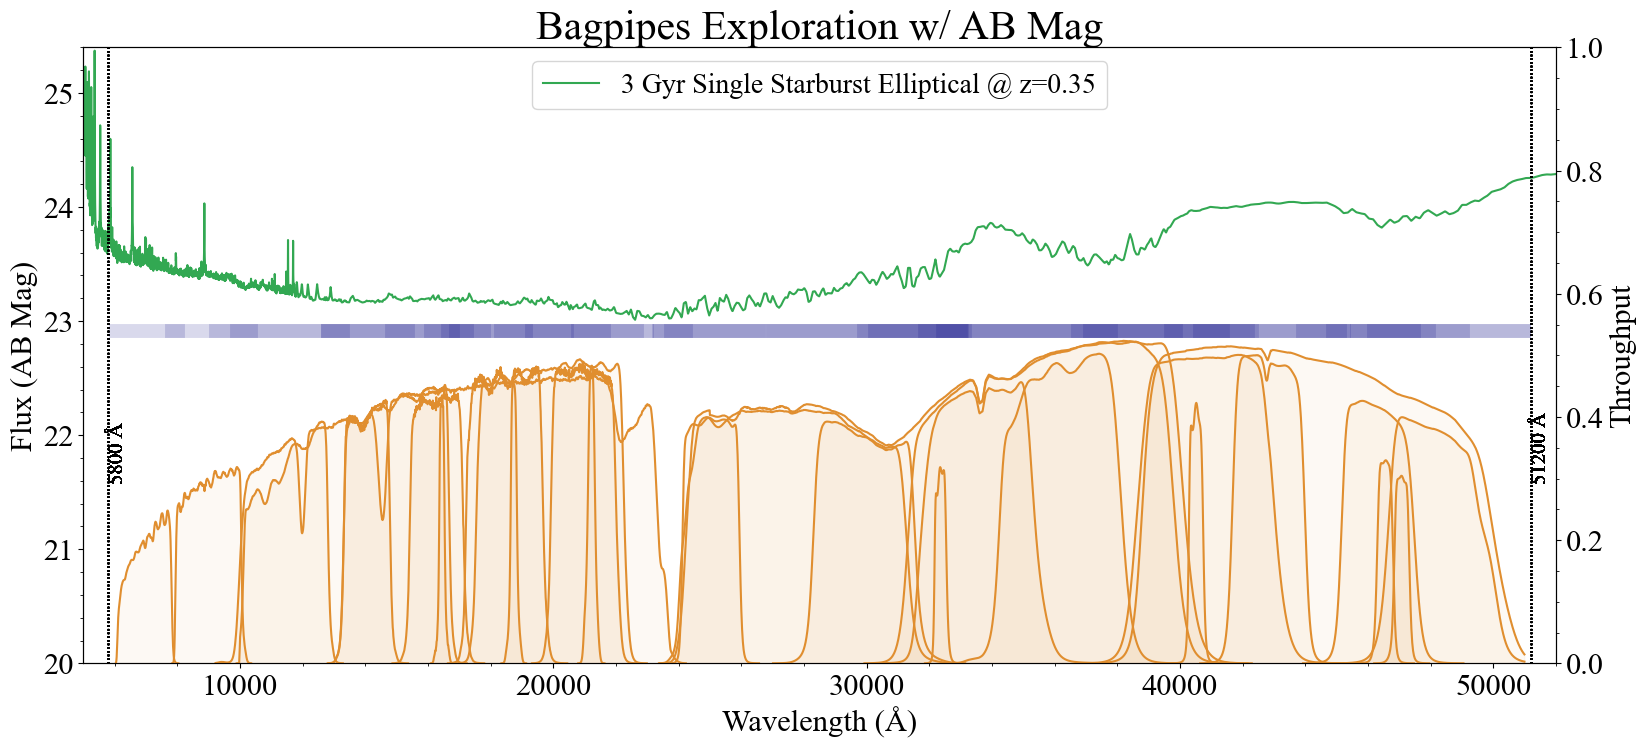

In [16]:
# Numerator = integrate(fnu*T(nu)/nu over dnu)
# Denominator = integrate(T(nu)/nu over dnu)
# mag = -2.5*log10(numerator/denominator)-48.6

#fig, ax = model.plot(show = False)
#print(ax)
#ax[0].set_xlabel('lambda / A')
#ax[0].set_xlim(4000, 49000)

x = model.wavelengths * (1 + model_components['redshift'])
y = model.spectrum_full #the graph gives 10^-18.0 erg s^-1 cm^-2 A^-1

# print('F𝝀:') #10^-18.0 erg s^-1 cm^-2 A^-1
# print(y)

#fig, ax = plt.subplots(figsize=(19,8))
#plt.plot(x, y, label='Plot', drawstyle='default', color='navy')
#plt.xscale('linear')
#plt.yscale('linear')
#ax.minorticks_on()
#ax.set_xlabel('Wavelength (Å)', fontsize=22)
#ax.set_ylabel('F lambda (10^-18.0 erg s^-1 cm^-2 A^-1)')
#ax.set_ylim(0, np.max(y))
#ax.set_xlim(5000, 45000)

ab_mag = []
f_nu = []

for n in range(0, len(y), 1):
    conversion = (((x[n])**2)/(2.99e18)) * y[n]
    f_nu.append(conversion)

# print('F𝜈:') #10^-29.0 erg s^-1 cm^-2 Hz^-1
# print(f_nu)

#fig, ax = plt.subplots(figsize=(19,8))
#plt.plot(x, f_nu, label='Plot', drawstyle='default', color='red')
#plt.xscale('linear')
#plt.yscale('linear')
#ax.minorticks_on()
#ax.set_xlabel('Wavelength (Å)', fontsize=22)
#ax.set_ylabel('F nu (10^-29.0 erg s^-1 cm^-2 Hz^-1)')
#ax.set_ylim(0, np.max(f_nu))
#ax.set_xlim(5000, 45000)

for n in range(0, len(f_nu), 1):
    if float(f_nu[n]) != 0:
        AB = (-2.5 * np.log10(float(f_nu[n]))) - 48.6
        ab_mag.append(float(AB))
    else:
        ab_mag.append(0)

# print('Wavelength')
# print(x)

# print('AB Mag:') #Mag
# print(ab_mag)

# CONTINUUM SPECTRA PLOTTING

fig, ax = plt.subplots(figsize=(19,8))

wavs = x
flux = ab_mag

plt.xscale('linear')
plt.yscale('linear')

Con, = ax.plot(wavs, flux, drawstyle='default', color='#32A852', label=str(exp["age"]) + ' Gyr Single Starburst Elliptical @ z=' + str(model_components["redshift"]))

ax.set_xlabel('Wavelength (Å)', fontsize=22)
ax.set_ylabel('Flux (AB Mag)', fontsize=22)

ax.set_ylim(20, 25.4)
ax.set_xlim(5000, 52000)

# FILTER PLOTTING

ax2 = ax.twinx()

for filename in os.listdir('filters/'):
    if 'JWST' in filename:
        file = open('filters/'+filename, 'r')

        wavsrange = []
        through = []

        for line in file:
            pair = line.strip().split(' ')
            wavsrange.append(float(pair[0]))
            through.append(float(pair[1]))
        
        ax2.plot([wavsrange[0], wavsrange[-1]], [0.54, 0.54], color='navy', alpha=0.15, lw=10)
        ax2.axvline(x=5800, color='black', lw=1, ls=':')
        ax2.annotate('5800 Å', (5800,.3), color='black', rotation=90, size=15, clip_on=True)
        ax2.axvline(x=51200, color='black', lw=1, ls=':')
        ax2.annotate('51200 Å', (51200,.3), color='black', rotation=90, size=15, clip_on=True)

        ax2.plot(wavsrange, through, color='#E08E2F')
        ax2.fill_between(wavsrange, through, color='#E08E2F', alpha=0.05)

ax2.set_ylabel('Throughput', fontsize=22)

ax2.set_ylim(0, 1)
ax2.set_xlim(5000,52000)

# TICK ADJUSTMENTS

ax.minorticks_on()
ax.tick_params(labelsize=22)
ax2.minorticks_on()
ax2.tick_params(labelsize=22)
plt.rcParams.update({'font.serif': "Times New Roman",
                     'font.family': "serif"                  
                    })

# LEGEND

ax.legend(handles=[Con], loc='upper center', prop={'family': 'Times New Roman', 'size': '20'})

plt.title('Bagpipes Exploration w/ AB Mag', fontsize=30)
fig_html = mpld3.fig_to_html(fig)
components.html(fig_html, height=600)
plt.show()

#m = -2.5*np.log10(Fnu) - 48.6
#[Y ABnu] = -2.5 * log([X ergs/cm^2/s/A]) - 2.402 - 5.0 * log(lambda A) <-- TRY THISS!!!!

#Balmer 4000 A Break -- elliptical old galaxy feature!

#NIRCam Filter curves
#Explore layering with JWST Filters -- summing up from one point other (value is synthetic astronomy (subtract one from other you get colour))
#Convert to AB Mag first before this


#F090
#F115W
#F150W
#F200W
#F277W
#F336W
#F444W

/var/folders/qy/trts8c7d3dg4b7k01x7trmlw0000gn/T/ipykernel_74743/476337039.py:53: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(np.min(model), np.max(model))


TypeError: '>' not supported between instances of 'model_galaxy' and 'model_galaxy'

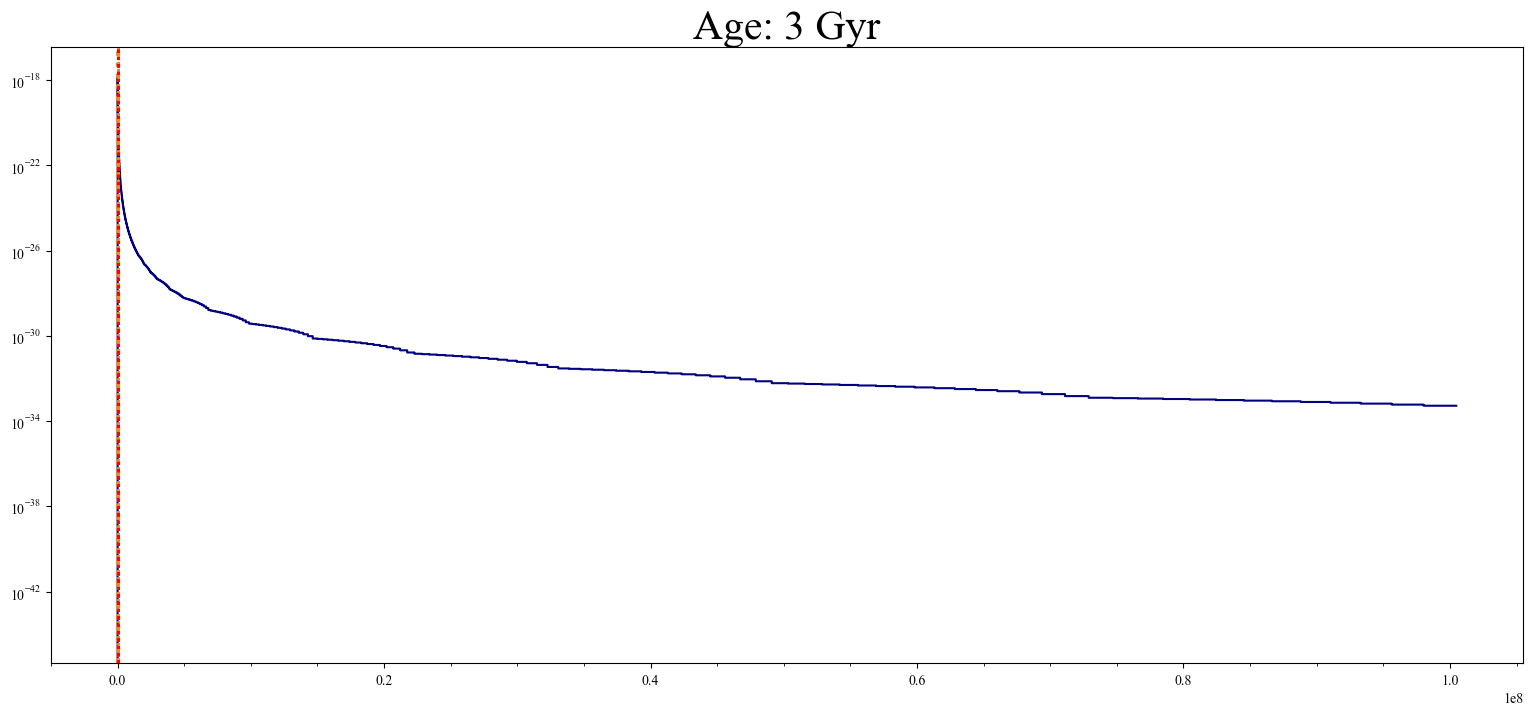

In [9]:
fig, ax = plt.subplots(1, sharex=True, figsize=(19,8))
#fig, ax = model.plot(show=False)
x = model.wavelengths 
y = model.spectrum_full * (1 + model_components['redshift'])
plt.step(x, y, label='Plot', drawstyle='default', color='navy')
plt.xscale('linear')
plt.yscale('log')

ax.minorticks_on()
ax.axvline(x=6563, color='#E08E2F',lw=3,ls=':')
ax.annotate('Halpha',(6563,10),xytext=(6563,10),color='black',rotation=90,clip_on=True)

#ax.set_xlabel('Angstrom (λ)', fontsize=22)
#ax.set_ylabel('Flux (10^38.0 erg s^-1 A^-1)', fontsize=22)

plt.title('Age: ' + str(exp["age"]) + ' Gyr', fontsize=30)

#label_size = 24
#matplotlib.rcParams['xtick.labelsize'] = label_size 
#matplotlib.rcParams['ytick.labelsize'] = label_size
#ax.tick_params(top=True, length=10,width=2)

# Emission/Absorption Labelling
lwave = [912,1026,1215.67,1240,1260,1296.3,1323.9,1302,1304,1335,\
         1343.354,1394,1403,1417.237,1427.85,1501.76,1527,1548,1550,1608,\
         1640,1671,1855,1863,1909,2326,2344,2374,2424,2587,\
         2600,2796,2799,3346,3426,3727,3798,3835,3889,3933,3968,\
         3970,4102,4304,4340,4861,4959,5007,5167,5173,5184,\
         5876,5889,5896,6548,6563,6583,6716,6730,6875,7040,\
         7680,8190,8520]
lname = ['Lylim','Lyb','Lya','NV','SiII','CIII/SiIII','CII/NIII','SiII/OI',' ','CII',\
         'OIV','SiIV',' ','SiIII','CIII','SV','SiII','CIV',' ','FeII', \
         'HeII','AlII','AlIII','.','CIII','CII','FeII','FeII','NeIV','FeII',\
         '.','MgII - absorp',' ','NeV','NeV','[OII] - emi','Htheta','Heta','Hzeta','K','H,Hepsilon',\
         ' ','Hdelta','Gb','Hgamma','Hbeta - absorp','[OIII]','[OIII]',' ','MgI',' ',\
         'HeI,NaD','.','.','NII','Halpha','.','SII','.','Bb','TiO',\
         'KI','Na','Cs']

lrun = len(lwave)
for i in range(lrun):
    tmpwl = lwave[i] * (1 + model_components['redshift'])
    ax.axvline(x=tmpwl, color='#E08E2F', lw=1, ls=':')
    ax.annotate(lname[i], (tmpwl,1e+38), xytext=(tmpwl-5,1e+38), color='#E08E2F', rotation=90, clip_on=True)

skylines = [5577, 5895, 6301, 6875, 7246, 7600]
    
for o in range(len(skylines)):
    ax.axvline(x=skylines[o], color='red', lw=2, ls=':')
    ax.annotate('Skyline', (skylines[o], 5000), xytext=(skylines[o],10),color='red',rotation=90,clip_on=True)

# Wavelength Bounds
#ax.set_xlim(np.min(x), np.max(x))
ax.set_xlim(np.min(model), np.max(model))

# Flux Bounds
ax.set_ylim(np.min(model), np.max(model))

plt.tight_layout()
plt.show()

fig.show()

NameError: name 'model_av0' is not defined

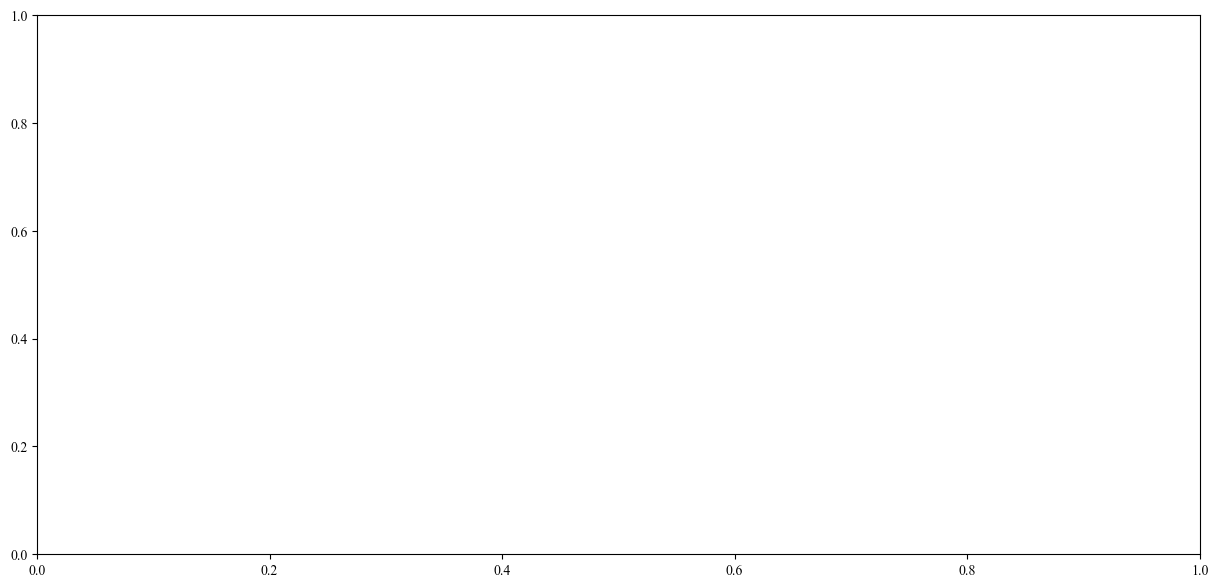

In [12]:
fig, ax = plt.subplots(figsize = (15,7))

# Sort out axis limits
xmin = model_av0.filter_set.eff_wavs.min()
xmax = model_av0.filter_set.eff_wavs.max()

####AV0
redshifted_wavs_av0 = model_av0.wavelengths*(1.+model_av0.model_comp["redshift"])
spec_mask_av0 = ((redshifted_wavs_av0 > 10**xmin) & (redshifted_wavs_av0 < 10**xmax))

####AV1
redshifted_wavs_av1 = model_av1.wavelengths*(1.+model_av1.model_comp["redshift"])

####AV2
redshifted_wavs_av2 = model_av2.wavelengths*(1.+model_av2.model_comp["redshift"])
spec_mask_av2 = ((redshifted_wavs_av2 > 10**xmin) & (redshifted_wavs_av2 < 10**xmax))

ymax = 1.05*np.max(model_av0.spectrum_full)
y_scale = int(np.log10(ymax))-1

# print('YSCALE')
# print(y_scale)

ax.set_xlim(xmin - 2000, xmax + 2000)
ax.set_ylim(0, ymax*10**-y_scale)

ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.xscale('linear')
plt.yscale('linear')

ax.set_xlabel('Wavelength (Å)', fontsize=18)
ax.set_ylabel('Flux (1e{} erg s^-1 cm^-2 Å^-1)'.format(y_scale), fontsize=18)

# Plot the data
Av0, = ax.plot(redshifted_wavs_av0,
        model_av0.spectrum_full*10**-y_scale, color='#32a852', 
        zorder = 1, label='Av = 0')
ax.scatter(model_av0.filter_set.eff_wavs,
           model_av0.photometry*10**-y_scale,
           color='#25783c', s=100, zorder = 1)

Av1, = ax.plot(redshifted_wavs_av1,
        model_av1.spectrum_full*10**-y_scale, color='#5675db',
        zorder = 1, label='Av = 1')
ax.scatter(model_av1.filter_set.eff_wavs,
           model_av1.photometry*10**-y_scale,
           color='#253878', s=100, zorder = 1)

Av2, = ax.plot(redshifted_wavs_av2,
        model_av2.spectrum_full*10**-y_scale, color='#8d56db',
        zorder = 1, label='Av = 2')
ax.scatter(model_av2.filter_set.eff_wavs,
           model_av2.photometry*10**-y_scale,
           color='#5d3596', s=100, zorder = 1)

ax.legend(handles=[Av0, Av1, Av2], loc='upper left', prop={'family': 'Times New Roman', 'size': '20'})

In [11]:
xmin = model_av0.filter_set.eff_wavs.min()
xmax = model_av0.filter_set.eff_wavs.max()

####AV0
redshifted_wavs_av0 = model_av0.wavelengths*(1.+model_av0.model_comp["redshift"])
spec_mask_av0 = ((redshifted_wavs_av0 > 10**xmin) & (redshifted_wavs_av0 < 10**xmax))

####AV1
redshifted_wavs_av1 = model_av1.wavelengths*(1.+model_av1.model_comp["redshift"])

####AV2
redshifted_wavs_av2 = model_av2.wavelengths*(1.+model_av2.model_comp["redshift"])
spec_mask_av2 = ((redshifted_wavs_av2 > 10**xmin) & (redshifted_wavs_av2 < 10**xmax))

ymax = 1.05*np.max(model_av0.spectrum_full)
y_scale = int(np.log10(ymax))-1

# print('YSCALE')
# print(y_scale)

ax.set_xlim(xmin - 2000, xmax + 2000)
ax.set_ylim(0, ymax*10**-y_scale)

ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.xscale('linear')
plt.yscale('linear')

ax.set_xlabel('Wavelength (Å)', fontsize=18)
ax.set_ylabel('Flux (1e{} erg s^-1 cm^-2 Å^-1)'.format(y_scale), fontsize=18)

# Plot the data
Av0, = ax.plot(redshifted_wavs_av0,
        model_av0.spectrum_full*10**-y_scale, color='#32a852', 
        zorder = 1, label='Av = 0')
ax.scatter(model_av0.filter_set.eff_wavs,
           model_av0.photometry*10**-y_scale,
           color='#25783c', s=100, zorder = 1)

Av1, = ax.plot(redshifted_wavs_av1,
        model_av1.spectrum_full*10**-y_scale, color='#5675db',
        zorder = 1, label='Av = 1')
ax.scatter(model_av1.filter_set.eff_wavs,
           model_av1.photometry*10**-y_scale,
           color='#253878', s=100, zorder = 1)

Av2, = ax.plot(redshifted_wavs_av2,
        model_av2.spectrum_full*10**-y_scale, color='#8d56db',
        zorder = 1, label='Av = 2')
ax.scatter(model_av2.filter_set.eff_wavs,
           model_av2.photometry*10**-y_scale,
           color='#5d3596', s=100, zorder = 1)

ax.legend(handles=[Av0, Av1, Av2], loc='upper left', prop={'family': 'Times New Roman', 'size': '20'})

NameError: name 'model_av0' is not defined

['JWST_NIRCam.F405N.dat', 'JWST_NIRCam.F277W.dat', 'JWST_NIRCam.F200W.dat', '.DS_Store', 'Icon\r', 'JWST_NIRCam.F115W.dat', 'JWST_NIRCam.F182M.dat', 'JWST_NIRCam.F360M.dat', 'JWST_NIRCam.F070W.dat', 'HST_ACS_HRC.F814W.dat', 'JWST_NIRCam.F212N.dat', 'JWST_NIRCam.F150W2.dat', 'JWST_NIRCam.F480M.dat', 'JWST_NIRCam.F300M.dat', 'JWST_NIRCam.F140M.dat', 'JWST_NIRCam.F250M.dat', 'JWST_NIRCam.F323N.dat', 'JWST_NIRCam.F460M.dat', 'HST_WFC3_IR.F110W.dat', 'JWST_NIRCam.F335M.dat', 'JWST_NIRCam.F162M.dat', 'JWST_NIRCam.F090W.dat', 'JWST_NIRCam.F356W.dat', 'JWST_NIRCam.F210M.dat', 'JWST_NIRCam.F466N.dat', 'JWST_NIRCam.F150W.dat', 'JWST_NIRCam.F322W2.dat', 'JWST_NIRCam.F470N.dat', 'JWST_NIRCam.F410M.dat', 'JWST_NIRCam.F164N.dat', 'HST_WFC3_IR.F160W.dat', 'JWST_NIRCam.F444W.dat', 'JWST_NIRCam.F187N.dat', 'JWST_NIRCam.F430M.dat']


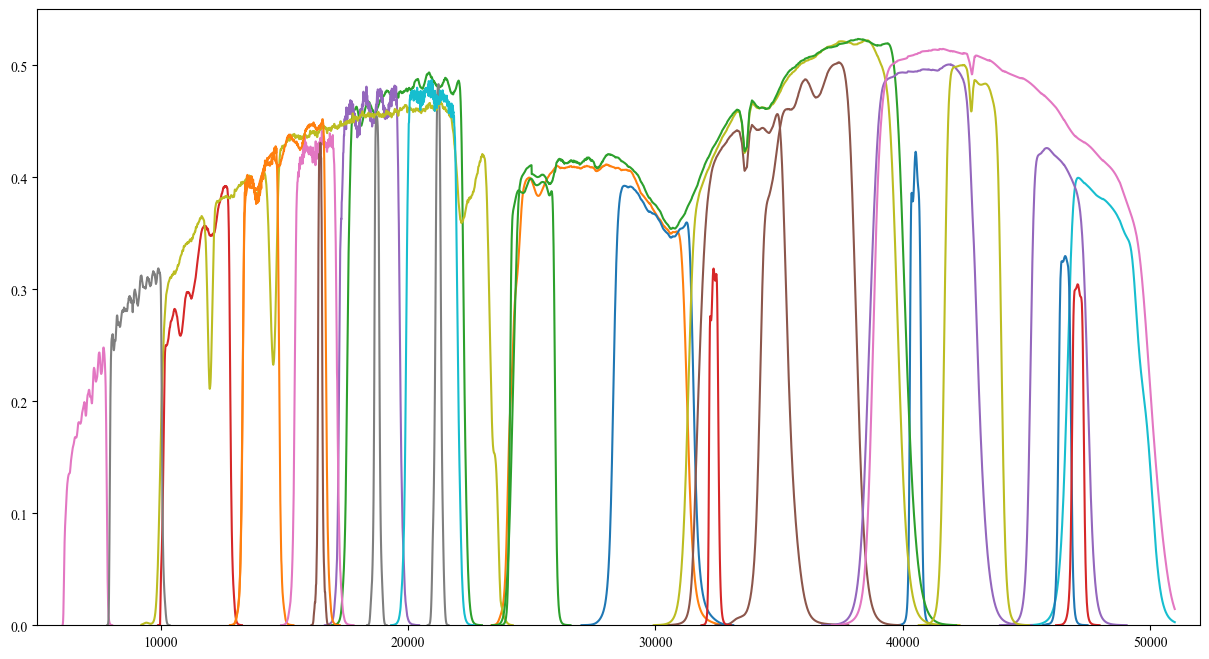

In [10]:
import bagpipes as pipes
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scienceplots as scipl
import math
import os

fig, ax = plt.subplots(figsize = (15,8))

print(os.listdir('filters/'))

colours={'JWST_NIRCam.F405N.dat': 'red', 'JWST_NIRCam.F277W.dat': 'blue', 'JWST_NIRCam.F200W.dat': 'pink', 'JWST_NIRCam.F115W.dat': 'purple', 'JWST_NIRCam.F182M.dat': 'cyan'}

for filename in os.listdir('filters/'):
    if 'JWST' in filename:
        # print(filename)
        file = open('filters/'+filename, 'r')

        wavs = []
        through = []

        for line in file:
            pair = line.strip().split(' ')
            wavs.append(float(pair[0]))
            through.append(float(pair[1]))

        # print(wavs)
        # print(through)

        ax.plot(wavs, through)
        ax.set(xlim=(5000, 52000), ylim=(0, 0.55))

plt.show()

# Fix the colours
